# Cirrhosis classification

In this notebook, we will run a permutation test on a relatively often used cirrhosis classification dataset [[Qin, et al 2014]](https://www.nature.com/articles/nature13568). Permutation test are used to assess the performance of the method in regards to random data and to evaluate the amount of data leakage present in the method.

In [9]:
import numpy as np
import pandas as pd
import sys

#This should be the location where you have stored the codebase on your computer
sys.path.append('C:\\Users\\basvo\\Documents\\GitHub\\BV_codebase')

import machine_learning
import metagenomics

In [10]:
# location on the computer where the data is stored
filepath = '../toy_datasets/cirrhosis/cirrhosis_mp4_abundance_species.csv'

# Load in the file
df = pd.read_csv(filepath, index_col=0)
df.head()

,k__Archaea|p__Candidatus_Thermoplasmatota|c__Thermoplasmata|o__Methanomassiliicoccales|f__Candidatus_Methanomethylophilaceae|g__Candidatus_Methanomethylophilus|s__Candidatus_Methanomethylophilus_alvus,k__Archaea|p__Candidatus_Thermoplasmatota|c__Thermoplasmata|o__Methanomassiliicoccales|f__Methanomassiliicoccaceae|g__Methanomassiliicoccaceae_unclassified|s__Methanomassiliicoccaceae_archaeon_DOK,k__Archaea|p__Candidatus_Thermoplasmatota|c__Thermoplasmata|o__Methanomassiliicoccales|f__Methanomassiliicoccaceae|g__Methanomassiliicoccaceae_unclassified|s__Methanomassiliicoccaceae_unclassified_SGB380,k__Archaea|p__Euryarchaeota|c__CFGB343|o__OFGB343|f__FGB343|g__GGB781|s__GGB781_SGB1024,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobacteriaceae_unclassified|s__Methanobacteriaceae_archaeon,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_oralis,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_smithii,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanosphaera|s__Methanosphaera_cuniculi,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanosphaera|s__Methanosphaera_stadtmanae,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinobacteria_unclassified|f__Actinobacteria_unclassified|g__GGB39918|s__GGB39918_SGB47522,...,k__Bacteria|p__Tenericutes|c__Mollicutes|o__Mycoplasmatales|f__Mycoplasmataceae|g__Mycoplasma|s__Mycoplasma_hominis,k__Bacteria|p__Verrucomicrobia|c__CFGB2164|o__OFGB2164|f__FGB2164|g__GGB6132|s__GGB6132_SGB8779,k__Bacteria|p__Verrucomicrobia|c__CFGB2165|o__OFGB2165|f__FGB2165|g__GGB6133|s__GGB6133_SGB8780,k__Bacteria|p__Verrucomicrobia|c__Opitutae|o__Opitutales|f__Opitutales_unclassified|g__GGB6128|s__GGB6128_SGB8774,k__Bacteria|p__Verrucomicrobia|c__Opitutae|o__Opitutales|f__Opitutales_unclassified|g__Opitutales_unclassified|s__Opitutales_bacterium,k__Bacteria|p__Verrucomicrobia|c__Opitutae|o__Puniceicoccales|f__Puniceicoccaceae|g__Puniceicoccaceae_unclassified|s__Puniceicoccaceae_bacterium_Marseille_Q1082,k__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Akkermansiaceae|g__Akkermansia|s__Akkermansia_muciniphila,k__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Akkermansiaceae|g__GGB6529|s__GGB6529_SGB9222,k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Saccharomycetaceae|g__Saccharomyces|s__Saccharomyces_cerevisiae,k__Eukaryota|p__Eukaryota_unclassified|c__Eukaryota_unclassified|o__Eukaryota_unclassified|f__Eukaryota_unclassified|g__Blastocystis|s__Blastocystis_sp_subtype_1
HD10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
HD11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.857436,0.0,0.0,0.0
HD12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
HD13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
HD14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [11]:
df = metagenomics.utils.remove_all_zero_species(df)
df = metagenomics.utils.sparsity_selection(df,0.05)
df = metagenomics.utils.abundance_selection(df,50)

there were 0 removed from the dataset


In [12]:
idx = list(df.index)

y = []
for i in idx:
    if i[0] == 'L':
        y.append(1)
    else:
        y.append(0)

In [13]:
X = np.asarray(df, dtype=float)
y = np.asarray(y, dtype=int)

feature_names = list(df.columns)

In [14]:
method = machine_learning.models.tree
method_params = {
    'algo':'xtr',
    'task':'classify',
    'imp_algo': machine_learning.utils.get_perm_imp,
    'n_cv_folds':3,
    'n_cv_repeats':1,
}

test_size = 0.2     # fraction of the data to be used for validation
n_splits = 10       # number of stability runs to perform
verbosity = 1       # level of verbosity to report

In [15]:
results_dict = machine_learning.utils.perform_stability_runs_classification(
    X,
    y,
    test_size,
    n_splits,
    feature_names = feature_names,
    method=method,
    method_params=method_params,
    return_importances=True,
    verbosity=verbosity,
)

shuffle 1 done
train_scores: 0.9863221884498481 +\- 0.0
val_scores: 0.9236017169614984 +\- 0.0
test_scores: 0.9329710144927537 +\- 0.0

shuffle 2 done
train_scores: 0.993161094224924 +\- 0.006838905775075954
val_scores: 0.9260828563995838 +\- 0.002481139438085367
test_scores: 0.9112318840579711 +\- 0.021739130434782594



In [16]:
results_dict_perm = machine_learning.utils.perform_permutation_test_classification(
    X,
    y,
    test_size,
    n_splits,
    feature_names = feature_names,
    method=method,
    method_params=method_params,
    return_importances=True,
    verbosity=verbosity,
)

shuffle 1 done
train_scores: 1.0 +\- 0.0
val_scores: 0.6453036478205573 +\- 0.0
test_scores: 0.401268115942029 +\- 0.0

shuffle 2 done
train_scores: 0.8843815758709375 +\- 0.11561842412906248
val_scores: 0.624284960689097 +\- 0.021018687131460267
test_scores: 0.4433876811594203 +\- 0.0421195652173913



p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

true vs. permuted: t-test independent samples, P_val:1.011e-02 t=9.870e+00


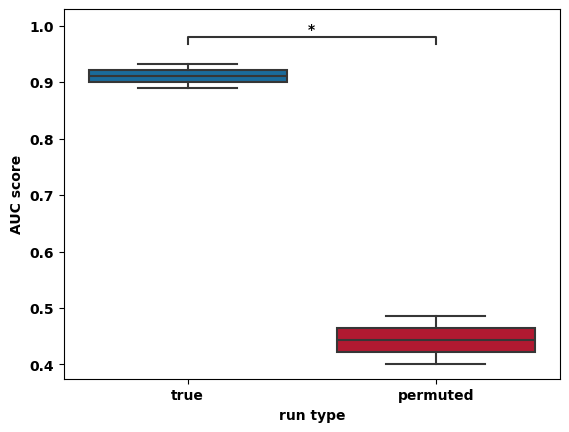

In [20]:
def perm_test_boxplot(results_dict_true, results_dict_perm):

    scores_true = pd.DataFrame(results_dict_true['test_scores'])
    scores_true.columns = ['AUC score']
    scores_true['run type'] = 'true'

    scores_perm = pd.DataFrame(results_dict_perm['test_scores'])
    scores_perm.columns = ['AUC score']
    scores_perm['run type'] = 'permuted'

    scores_df = pd.concat([scores_true, scores_perm], axis=0)

    fig = machine_learning.plotting.boxplot_with_test(scores_df, 'run type', 'AUC score')

perm_test_boxplot(results_dict, results_dict_perm)